# Transform your Data
The point of transforming your data is to make it as easy as possible for your algorithms to distinguish signal from noise.  Each data science project will require different transformations and creative transformations are often the key to a successful AI project.  First, load in your Workspace, Datastore and Datasets.<br><br>


In [21]:
# Load Azure Libaries
from azureml.core import Datastore
from azureml.core.dataset import Dataset
from azureml.core.workspace import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
from azure.storage.blob import BlockBlobService
import pandas as pd
import numpy as np
import json
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
# Retrieve your workspace by name by filling in the lower case values between double quotes
ws = Workspace.get(name="ancient-rivers-ml-workspace",
        subscription_id="47a7ec0c-37ad-428b-9114-b87ea1057632",
        resource_group="xeek-ancient-rivers")

In [23]:
# Retrieve your Datastore by name by filling in the lower case values between double quotes
datastore_name = "ancientrivers"
datastore = Datastore.get(ws, datastore_name)

In [24]:
# Retrieve your Datasets by name by filling in the lower case values between double quotes
dataset_name_train = "ancient-rivers-train-refined"
dataset_name_test  = "ancient-rivers-test-refined"

# Load Data in as Tabular Datasets
training_data = Dataset.get_by_name(ws, dataset_name_train, version='latest')
testing_data  = Dataset.get_by_name(ws, dataset_name_test, version='latest')


In [25]:
# Convert your tabular dataset to pandas data frames
testRefinedDF = testing_data.to_pandas_dataframe()
trainRefinedDF = training_data.to_pandas_dataframe()

# It's time to start working with your data!
This next step should be customized to fit each project based on your understanding of the problem and the data.<br>
You should understand your data, transform your data, and save it as a Dataset so everyone on your workspace can access it.<br>

Common transformations include, but are not limited to:<br>
- Rebalancing your Dependent Variable for Classification Problems (The column you are trying to predict)
- Transforming your Dependent Variable to follow a Normal Distribution for Regression Problems
- Removing outliers
- Smoothing Noisy Numeric Indepedent Variables (IVs)
- Binning Numeric IVs
- Binning Categorical IVs
- Create New Columns based on your refined data
- Impute Null Values across the Dataset
- Create New Columns to indicate where Null Values existed before imputation for each column

In [26]:
# Since each transformation is problem specific, you will have to research your data to determine what is appropriate.
# For an example, looked at the filled version of this notebook.

In [27]:
# View your refined data
testRefinedDF.head(5)

,RowID,WellID,GR
0,0,5000,134.9
1,1,5000,127.0
2,2,5000,133.2
3,3,5000,134.4
4,4,5000,135.7


In [28]:
# View your refined data
trainRefinedDF.head(5)

,RowID,WellID,GR,Label
0,0,0,99.0,Default Layer
1,1,0,105.6,Default Layer
2,2,0,105.9,Default Layer
3,3,0,113.5,Default Layer
4,4,0,101.5,Default Layer


Default Layer    555820
Layer 4          127485
Layer 2          124570
Layer 1          120753
Layer 3          119672
Name: Label, dtype: int64


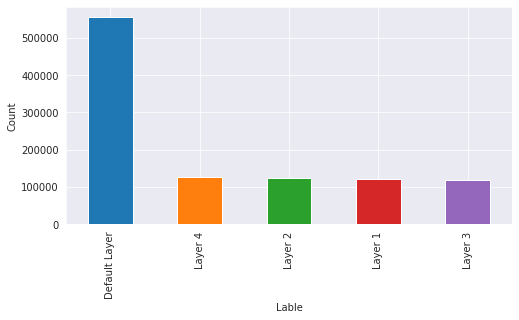

In [29]:
# Step 1 - Visualize your label distribution
# AutoML works as long as your data has up to a 20 to 1 balance between classes.  This data is roughly 4 to 1.
# No rebalancing is required
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
trainRefinedDF["Label"].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Lable')
print(trainRefinedDF["Label"].value_counts())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bb816bdd8>]],
      dtype=object)

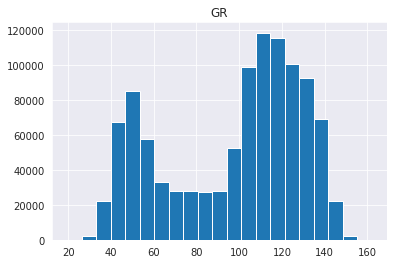

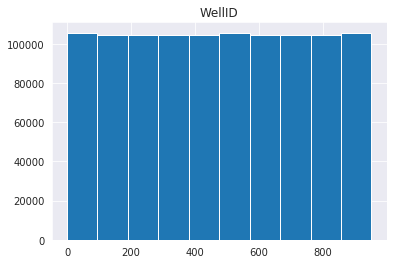

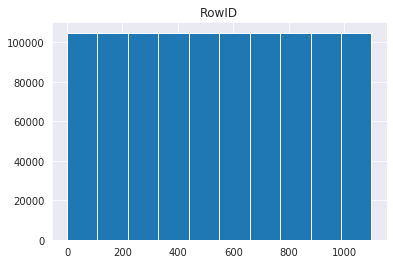

In [30]:
# Step 2 - Outlier Detection and Handling
# WellID and RowID have an equal number of rows per value.  This is expected.
# GR has a bimodal non-normal distribution of values.  Since this is an IV, used to predict the label, this is fine.
# GR does not have any extreme trailing ends to the right or left, so we will not remove outliers

trainRefinedDF.hist(column="GR",bins=21)  # Plot a single column
trainRefinedDF.hist(column="WellID")  # Plot a single column
trainRefinedDF.hist(column="RowID")  # Plot a single column


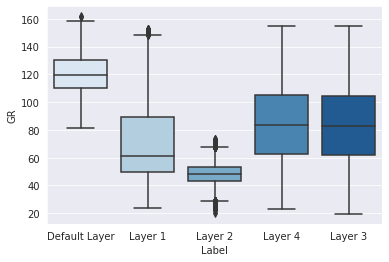

In [31]:
# Step 2 - Outlier Detection and Handling
# Check to see if any of the label columns have radiation levels outside of expected norms
# Nothing too extreme seems to be detected
sns.boxplot( x=trainRefinedDF["Label"], y=trainRefinedDF["GR"], palette="Blues");
plt.show()

In [32]:
# Step 3 - Smoothing Noisy Numeric Variables
# GR is noisy and needs to be smoothed.  We will create a smoothing function and apply it.

# Create a smoothing function.  This was provided in Xeek's Ancient Rivers' contest.

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [33]:
#Feature engineering
wellCountTrain = trainRefinedDF["WellID"].nunique()
print(wellCountTrain)

wellCountTest =  testRefinedDF["WellID"].nunique()
print(wellCountTest)

953
350


hamming


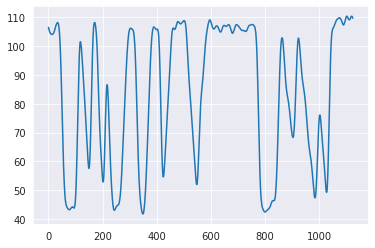

In [34]:
# Step 3 - Smoothing Noisy Numeric Variables
# Apply the smoothing function

#smoothing the signal - finding the best algo
wl = 27
windows=['hamming']
for w in windows:
    plt.plot(smooth(trainRefinedDF[trainRefinedDF.WellID==0].GR,wl,w))
    #hamming with window len 27 seems the best
    print(w)
    plt.show()

    
    
smoothed_GR = smooth(trainRefinedDF[trainRefinedDF.WellID==0].GR,27,'hamming')
smoothed_GR = smoothed_GR[13:-13]

smoothed_GR_test = smooth(testRefinedDF[testRefinedDF.WellID==5000].GR,27,'hamming')
smoothed_GR_test = smoothed_GR_test[13:-13]

for i in range(1,wellCountTrain): 
    smoothing_results = smooth(trainRefinedDF[trainRefinedDF.WellID==i].GR,27,'hamming')
    smoothed_GR = np.append(smoothed_GR,smoothing_results[13:-13])
    
for i in range(5001,5000+wellCountTest): 
    smoothing_results_test = smooth(testRefinedDF[testRefinedDF.WellID==i].GR,27,'hamming')
    smoothed_GR_test = np.append(smoothed_GR_test,smoothing_results_test[13:-13])

In [35]:
# Step 3 - Smoothing Raw Data with Smoothed Data in your training and test sets
# Round the Smoothed Data to 1 Decimal

trainTransformedV1 = trainRefinedDF
testTransformedV1 = testRefinedDF

trainTransformedV2 = trainTransformedV1
testTransformedV2 = testTransformedV1

trainTransformedV2['smoothedGR'] = smoothed_GR
trainTransformedV2.smoothedGR = trainTransformedV2.smoothedGR.round(1)
testTransformedV2['smoothedGR'] = smoothed_GR_test
testTransformedV2.smoothedGR = testTransformedV2.smoothedGR.round(1)

In [36]:
# Step 4 - Binning Numeric Variables
# Most of the first rows' GR values for wells ar 0
uniqueWellCount = trainTransformedV2.WellID.nunique()
labelpercentfirst = trainTransformedV2.groupby("WellID").first().Label.value_counts()/uniqueWellCount
labelpercentfirst

Default Layer    0.981112
Layer 1          0.005247
Layer 2          0.005247
Layer 3          0.004197
Layer 4          0.004197
Name: Label, dtype: float64

In [37]:
# Step 4 - Binning Numeric Variables
# While 0 is still prevalent at row 2, it's now nearly as prevalent as at row 1
uniqueWellCount = trainTransformedV2.WellID.nunique()
labelpercentfirst = trainTransformedV2.loc[trainTransformedV2['RowID'] == 2].Label.value_counts()/(uniqueWellCount)
labelpercentfirst

Default Layer    0.951731
Layer 1          0.015740
Layer 2          0.014690
Layer 4          0.012592
Layer 3          0.005247
Name: Label, dtype: float64

In [38]:
# Step 4 - Binning Numeric Variables

# Define a function to create a new column based on Row 
def firstrow(dataset):
    if dataset['RowID'] == 0:
        val = 'First'
    else:
        val = 'Other'
    return val

trainTransformedV2['FirstRow'] = trainTransformedV2.apply(firstrow,axis=1)
testTransformedV2['FirstRow'] = testTransformedV2.apply(firstrow,axis=1)

In [39]:
# Step 5 - Binning Categorical Variables - None exist in this dataset

Graphs


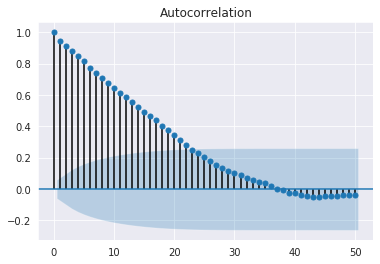

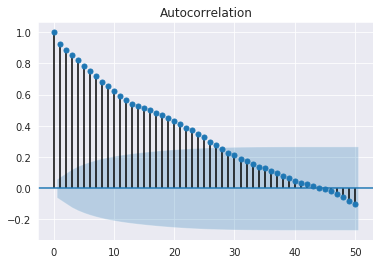

In [40]:
# Step 6 - Creating Columns from your other columns
# This is the most common way to get much more value from your data
# This also requires a lot of stastical knowledge, data knowledge and where data science expertise comes into play

# First, let's plot to find autocorrellation between GRs
# Full Correlation is found to be about 20 to 40 rows back based on well ID 
plot_acf(trainTransformedV2[trainTransformedV2.WellID==0].GR,lags=50)
plot_acf(trainTransformedV2[trainTransformedV2.WellID==952].GR,lags=50)
print('Graphs')

Graphs


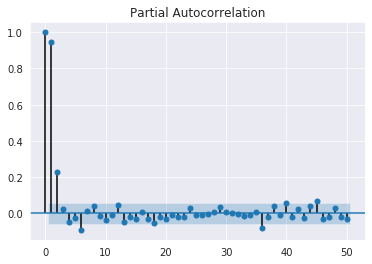

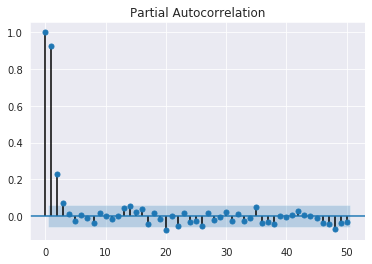

In [41]:
# Partial Autocorrelation is found 3 to 4 rows back depending on the Well ID.  
plot_pacf(trainTransformedV2[trainTransformedV2.WellID==0].GR,lags=50)
plot_pacf(trainTransformedV2[trainTransformedV2.WellID==952].GR,lags=50)
print('Graphs')

In [42]:
# Step 6 - Creating Columns from other Columns
# Based on the partial autocorrelation, it's important to have 4 lagging variables in front and back

trainTransformedV3 = trainTransformedV2
testTransformedV3 = testTransformedV2

featureWinLen = 4
for ii in range(1,featureWinLen+1):    
    high_condition = (trainTransformedV3["WellID"] == trainTransformedV3["WellID"].shift(ii))
    trainTransformedV3["smoothedGR"+str(ii)] = np.where(high_condition,trainTransformedV3["smoothedGR"].shift(ii),np.nan)
    low_condition = (trainTransformedV3["WellID"] == trainTransformedV3["WellID"].shift(-ii))
    trainTransformedV3["smoothedGR"+str(-ii)] = np.where(low_condition,trainTransformedV3["smoothedGR"].shift(-ii),np.nan)

for ii in range(1,featureWinLen+1):    
    high_condition = (testTransformedV3["WellID"] == testTransformedV3["WellID"].shift(ii))
    testTransformedV3["smoothedGR"+str(ii)] = np.where(high_condition,testTransformedV3["smoothedGR"].shift(ii),np.nan)
    low_condition = (testTransformedV3["WellID"] == testTransformedV3["WellID"].shift(-ii))
    testTransformedV3["smoothedGR"+str(-ii)] = np.where(low_condition,testTransformedV3["smoothedGR"].shift(-ii),np.nan)


In [43]:
# Step 6 - Creating Columns from other Columns
# To do the next steps, we will rely on Python's shift function to subtract data in different rows.
# This requires sorting our data.
trainTransformedV3.sort_values(by=['WellID','RowID'], inplace=True, ascending=True)
testTransformedV3.sort_values(by=['WellID','RowID'], inplace=True, ascending=True)
display(trainTransformedV3.head())
display(testTransformedV3.tail())

,RowID,WellID,GR,Label,smoothedGR,FirstRow,smoothedGR1,smoothedGR-1,smoothedGR2,smoothedGR-2,smoothedGR3,smoothedGR-3,smoothedGR4,smoothedGR-4
0,0,0,99.0,Default Layer,104.0,First,NaN,104.0,NaN,104.1,NaN,104.1,NaN,104.2
1,1,0,105.6,Default Layer,104.0,Other,104.0,104.1,NaN,104.1,NaN,104.2,NaN,104.3
2,2,0,105.9,Default Layer,104.1,Other,104.0,104.1,104.0,104.2,NaN,104.3,NaN,104.5
3,3,0,113.5,Default Layer,104.1,Other,104.1,104.2,104.0,104.3,104.0,104.5,NaN,104.6
4,4,0,101.5,Default Layer,104.2,Other,104.1,104.3,104.1,104.5,104.0,104.6,104.0,104.8


,RowID,WellID,GR,smoothedGR,FirstRow,smoothedGR1,smoothedGR-1,smoothedGR2,smoothedGR-2,smoothedGR3,smoothedGR-3,smoothedGR4,smoothedGR-4
384995,1095,5349,134.2,127.6,Other,127.5,127.7,127.5,127.7,127.4,127.7,127.3,127.7
384996,1096,5349,135.8,127.7,Other,127.6,127.7,127.5,127.7,127.5,127.7,127.4,NaN
384997,1097,5349,126.1,127.7,Other,127.7,127.7,127.6,127.7,127.5,NaN,127.5,NaN
384998,1098,5349,117.6,127.7,Other,127.7,127.7,127.7,NaN,127.6,NaN,127.5,NaN
384999,1099,5349,132.6,127.7,Other,127.7,NaN,127.7,NaN,127.7,NaN,127.6,NaN


In [44]:
# Step 6 - Creating Columns from other Columns
# Based on the full autocorrelation, it's likely that patterns 40 rows forward and back will be predictive.
# We will calculate the difference between smoothedGR, and average them in groups of 4

# Calculate Difference
train_diff_smoothed = trainTransformedV3[trainTransformedV3.WellID==0].GR - \
                        trainTransformedV3[trainTransformedV3.WellID==0].GR.shift(1)
test_diff_smoothed = testTransformedV3[testTransformedV3.WellID==5000].GR - \
                        testTransformedV3[testTransformedV3.WellID==5000].GR.shift(1)
train_diff_results_smoothed = train_diff_smoothed 
test_diff_results_smoothed = test_diff_smoothed 

for i in range(1,wellCountTrain): 
    train_diff_smoothed  = trainTransformedV3[trainTransformedV3.WellID==i].GR - \
                            trainTransformedV3[trainTransformedV3.WellID==i].GR.shift(1)
    train_diff_results_smoothed  = np.append(train_diff_results_smoothed ,train_diff_smoothed )
    
for i in range(5001,5000+wellCountTest): 
    test_diff_smoothed  = testTransformedV3[testTransformedV3.WellID==i].GR - \
                            testTransformedV3[testTransformedV3.WellID==i].GR.shift(1)
    test_diff_result_smoothed = np.append(test_diff_results_smoothed ,test_diff_smoothed )


trainTransformedV3['smoothedDifference'] = train_diff_results_smoothed.round(1)
testTransformedV3['smoothedDifference'] = test_diff_results_smoothed.round(1)
trainTransformedV3['smoothedDifference'] = trainTransformedV3['smoothedDifference'].fillna(value=0)
testTransformedV3['smoothedDifference'] = testTransformedV3['smoothedDifference'].fillna(value=0)

In [45]:
# Step 6 - Creating Columns from other Columns
# Use the difference column to average differences in groups of 4 from 4 to 40 lags backward
# Think of these as the general trend of the data

SMA_Results = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference = SMA_Results
SMA_Results_4 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(4).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_4 = SMA_Results_4
SMA_Results_8 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(8).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_8 = SMA_Results_8
SMA_Results_12 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(12).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_12 = SMA_Results_12
SMA_Results_16 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(16).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_16 = SMA_Results_16
SMA_Results_20 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(20).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_20 = SMA_Results_20
SMA_Results_24 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(24).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_24 = SMA_Results_24
SMA_Results_28 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(28).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_28 = SMA_Results_28
SMA_Results_32 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(32).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_32 = SMA_Results_32
SMA_Results_36 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(36).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_36 = SMA_Results_36
SMA_Results_40 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(40).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_40 = SMA_Results_40

for i in range(1,wellCountTrain): 
    SMA_Results = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference = np.append(SMA_SmoothedDifference,SMA_Results)
    SMA_Results_4 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(4).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_4 = np.append(SMA_SmoothedDifference_4,SMA_Results_4)
    SMA_Results_8 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(8).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_8 = np.append(SMA_SmoothedDifference_8,SMA_Results_8)
    SMA_Results_12 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(12).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_12 = np.append(SMA_SmoothedDifference_12,SMA_Results_12)
    SMA_Results_16 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(16).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_16 = np.append(SMA_SmoothedDifference_16,SMA_Results_16)
    SMA_Results_20 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(20).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_20 = np.append(SMA_SmoothedDifference_20,SMA_Results_20)
    SMA_Results_24 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(24).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_24 = np.append(SMA_SmoothedDifference_24,SMA_Results_24)
    SMA_Results_28 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(28).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_28 = np.append(SMA_SmoothedDifference_28,SMA_Results_28)
    SMA_Results_32 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(32).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_32 = np.append(SMA_SmoothedDifference_32,SMA_Results_32)
    SMA_Results_36 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(36).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_36 = np.append(SMA_SmoothedDifference_36,SMA_Results_36)
    SMA_Results_40 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(40).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_40 = np.append(SMA_SmoothedDifference_40,SMA_Results_40)
    
trainTransformedV3['smoothedDifference_SMA'] = SMA_SmoothedDifference.round(1)
trainTransformedV3['smoothedDifference_SMA_4'] = SMA_SmoothedDifference_4.round(1)
trainTransformedV3['smoothedDifference_SMA_8'] = SMA_SmoothedDifference_8.round(1)
trainTransformedV3['smoothedDifference_SMA_12'] = SMA_SmoothedDifference_12.round(1)
trainTransformedV3['smoothedDifference_SMA_16'] = SMA_SmoothedDifference_16.round(1)
trainTransformedV3['smoothedDifference_SMA_20'] = SMA_SmoothedDifference_20.round(1)
trainTransformedV3['smoothedDifference_SMA_24'] = SMA_SmoothedDifference_24.round(1)
trainTransformedV3['smoothedDifference_SMA_28'] = SMA_SmoothedDifference_28.round(1)
trainTransformedV3['smoothedDifference_SMA_32'] = SMA_SmoothedDifference_32.round(1)
trainTransformedV3['smoothedDifference_SMA_36'] = SMA_SmoothedDifference_36.round(1)
trainTransformedV3['smoothedDifference_SMA_40'] = SMA_SmoothedDifference_40.round(1)


In [46]:
# Step 6 - Creating Columns from other Columns
# Use the difference column to average differences in groups of 4 from 4 to 40 lags backward
# Think of these as the general trend of the data

SMA_Results = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference = SMA_Results
SMA_Results_4 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(4).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_4 = SMA_Results_4
SMA_Results_8 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(8).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_8 = SMA_Results_8
SMA_Results_12 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(12).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_12 = SMA_Results_12
SMA_Results_16 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(16).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_16 = SMA_Results_16
SMA_Results_20 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(20).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_20 = SMA_Results_20
SMA_Results_24 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(24).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_24 = SMA_Results_24
SMA_Results_28 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(28).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_28 = SMA_Results_28
SMA_Results_32 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(32).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_32 = SMA_Results_32
SMA_Results_36 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(36).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_36 = SMA_Results_36
SMA_Results_40 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(40).rolling(window=4,min_periods=1).mean()
SMA_SmoothedDifference_40 = SMA_Results_40

for i in range(5001,5000+wellCountTest): 
    SMA_Results = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference = np.append(SMA_SmoothedDifference,SMA_Results)
    SMA_Results_4 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(4).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_4 = np.append(SMA_SmoothedDifference_4,SMA_Results_4)
    SMA_Results_8 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(8).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_8 = np.append(SMA_SmoothedDifference_8,SMA_Results_8)
    SMA_Results_12 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(12).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_12 = np.append(SMA_SmoothedDifference_12,SMA_Results_12)
    SMA_Results_16 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(16).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_16 = np.append(SMA_SmoothedDifference_16,SMA_Results_16)
    SMA_Results_20 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(20).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_20 = np.append(SMA_SmoothedDifference_20,SMA_Results_20)
    SMA_Results_24 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(24).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_24 = np.append(SMA_SmoothedDifference_24,SMA_Results_24)
    SMA_Results_28 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(28).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_28 = np.append(SMA_SmoothedDifference_28,SMA_Results_28)
    SMA_Results_32 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(32).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_32 = np.append(SMA_SmoothedDifference_32,SMA_Results_32)
    SMA_Results_36 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(36).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_36 = np.append(SMA_SmoothedDifference_36,SMA_Results_36)
    SMA_Results_40 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(40).rolling(window=4,min_periods=1).mean()
    SMA_SmoothedDifference_40 = np.append(SMA_SmoothedDifference_40,SMA_Results_40)
    
testTransformedV3['smoothedDifference_SMA'] = SMA_SmoothedDifference.round(1)
testTransformedV3['smoothedDifference_SMA_4'] = SMA_SmoothedDifference_4.round(1)
testTransformedV3['smoothedDifference_SMA_8'] = SMA_SmoothedDifference_8.round(1)
testTransformedV3['smoothedDifference_SMA_12'] = SMA_SmoothedDifference_12.round(1)
testTransformedV3['smoothedDifference_SMA_16'] = SMA_SmoothedDifference_16.round(1)
testTransformedV3['smoothedDifference_SMA_20'] = SMA_SmoothedDifference_20.round(1)
testTransformedV3['smoothedDifference_SMA_24'] = SMA_SmoothedDifference_24.round(1)
testTransformedV3['smoothedDifference_SMA_28'] = SMA_SmoothedDifference_28.round(1)
testTransformedV3['smoothedDifference_SMA_32'] = SMA_SmoothedDifference_32.round(1)
testTransformedV3['smoothedDifference_SMA_36'] = SMA_SmoothedDifference_36.round(1)
testTransformedV3['smoothedDifference_SMA_40'] = SMA_SmoothedDifference_40.round(1)


In [47]:
# Step 6 - Creating Columns from other Columns
# We do the opposite to get the lags going forward instead of backward
# First we sort in the opposite direction
trainTransformedV3.sort_values(by=['WellID','RowID'], inplace=True, ascending=False)
testTransformedV3.sort_values(by=['WellID','RowID'], inplace=True, ascending=False)
display(trainTransformedV3.head())
display(testTransformedV3.tail())

,RowID,WellID,GR,Label,smoothedGR,FirstRow,smoothedGR1,smoothedGR-1,smoothedGR2,smoothedGR-2,...,smoothedDifference_SMA_4,smoothedDifference_SMA_8,smoothedDifference_SMA_12,smoothedDifference_SMA_16,smoothedDifference_SMA_20,smoothedDifference_SMA_24,smoothedDifference_SMA_28,smoothedDifference_SMA_32,smoothedDifference_SMA_36,smoothedDifference_SMA_40
1048299,1099,952,103.4,Default Layer,99.7,Other,99.8,NaN,99.7,NaN,...,-1.2,-1.9,-0.8,1.6,-0.7,-0.6,1.5,-0.5,-0.9,2.7
1048298,1098,952,101.4,Default Layer,99.8,Other,99.7,99.7,99.7,NaN,...,1.4,-0.8,-2.5,0.6,1.0,-1.6,-0.1,-1.0,1.4,2.1
1048297,1097,952,104.6,Default Layer,99.7,Other,99.7,99.8,99.6,99.7,...,-0.5,1.1,-0.2,1.3,-2.1,-2.8,3.5,0.9,-0.9,-0.0
1048296,1096,952,105.4,Default Layer,99.7,Other,99.6,99.7,99.6,99.8,...,-3.7,0.6,1.7,0.4,-2.2,2.6,-2.0,0.1,0.0,0.6
1048295,1095,952,92.9,Default Layer,99.6,Other,99.6,99.7,99.6,99.7,...,-1.9,-0.8,1.6,-0.7,-0.6,1.5,-0.5,-0.9,2.7,-2.5


,RowID,WellID,GR,smoothedGR,FirstRow,smoothedGR1,smoothedGR-1,smoothedGR2,smoothedGR-2,smoothedGR3,...,smoothedDifference_SMA_4,smoothedDifference_SMA_8,smoothedDifference_SMA_12,smoothedDifference_SMA_16,smoothedDifference_SMA_20,smoothedDifference_SMA_24,smoothedDifference_SMA_28,smoothedDifference_SMA_32,smoothedDifference_SMA_36,smoothedDifference_SMA_40
4,4,5000,135.7,132.7,Other,132.8,132.6,132.8,132.5,132.8,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5000,134.4,132.8,Other,132.8,132.7,132.8,132.6,132.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5000,133.2,132.8,Other,132.8,132.8,132.9,132.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5000,127.0,132.8,Other,132.9,132.8,NaN,132.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,5000,134.9,132.9,First,NaN,132.8,NaN,132.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Step 6 - Creating Columns from other Columns
# We transform training data first
# Since the sort is difference, we can use the exact same code to obtain results in the opposite direction

SMA_FORWARD_Results = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference = SMA_FORWARD_Results
SMA_FORWARD_Results_4 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(4).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_4 = SMA_FORWARD_Results_4
SMA_FORWARD_Results_8 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(8).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_8 = SMA_FORWARD_Results_8
SMA_FORWARD_Results_12 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(12).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_12 = SMA_FORWARD_Results_12
SMA_FORWARD_Results_16 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(16).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_16 = SMA_FORWARD_Results_16
SMA_FORWARD_Results_20 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(20).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_20 = SMA_FORWARD_Results_20
SMA_FORWARD_Results_24 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(24).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_24 = SMA_FORWARD_Results_24
SMA_FORWARD_Results_28 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(28).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_28 = SMA_FORWARD_Results_28
SMA_FORWARD_Results_32 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(32).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_32 = SMA_FORWARD_Results_32
SMA_FORWARD_Results_36 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(36).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_36 = SMA_FORWARD_Results_36
SMA_FORWARD_Results_40 = trainTransformedV3[trainTransformedV3.WellID==0].smoothedDifference.shift(40).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_40 = SMA_FORWARD_Results_40

for i in range(1,wellCountTrain): 
    SMA_FORWARD_Results = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference = np.append(SMA_FORWARD_SmoothedDifference,SMA_FORWARD_Results)
    SMA_FORWARD_Results_4 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(4).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_4 = np.append(SMA_FORWARD_SmoothedDifference_4,SMA_FORWARD_Results_4)
    SMA_FORWARD_Results_8 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(8).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_8 = np.append(SMA_FORWARD_SmoothedDifference_8,SMA_FORWARD_Results_8)
    SMA_FORWARD_Results_12 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(12).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_12 = np.append(SMA_FORWARD_SmoothedDifference_12,SMA_FORWARD_Results_12)
    SMA_FORWARD_Results_16 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(16).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_16 = np.append(SMA_FORWARD_SmoothedDifference_16,SMA_FORWARD_Results_16)
    SMA_FORWARD_Results_20 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(20).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_20 = np.append(SMA_FORWARD_SmoothedDifference_20,SMA_FORWARD_Results_20)
    SMA_FORWARD_Results_24 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(24).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_24 = np.append(SMA_FORWARD_SmoothedDifference_24,SMA_FORWARD_Results_24)
    SMA_FORWARD_Results_28 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(28).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_28 = np.append(SMA_FORWARD_SmoothedDifference_28,SMA_FORWARD_Results_28)
    SMA_FORWARD_Results_32 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(32).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_32 = np.append(SMA_FORWARD_SmoothedDifference_32,SMA_FORWARD_Results_32)
    SMA_FORWARD_Results_36 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(36).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_36 = np.append(SMA_FORWARD_SmoothedDifference_36,SMA_FORWARD_Results_36)
    SMA_FORWARD_Results_40 = trainTransformedV3[trainTransformedV3.WellID==i].smoothedDifference.shift(40).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_40 = np.append(SMA_FORWARD_SmoothedDifference_40,SMA_FORWARD_Results_40)
    
trainTransformedV3['smoothedDifference_SMA'] = SMA_FORWARD_SmoothedDifference.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_4'] = SMA_FORWARD_SmoothedDifference_4.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_8'] = SMA_FORWARD_SmoothedDifference_8.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_12'] = SMA_FORWARD_SmoothedDifference_12.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_16'] = SMA_FORWARD_SmoothedDifference_16.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_20'] = SMA_FORWARD_SmoothedDifference_20.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_24'] = SMA_FORWARD_SmoothedDifference_24.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_28'] = SMA_FORWARD_SmoothedDifference_28.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_32'] = SMA_FORWARD_SmoothedDifference_32.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_36'] = SMA_FORWARD_SmoothedDifference_36.round(1)
trainTransformedV3['smoothedDifference_SMA_FORWARD_40'] = SMA_FORWARD_SmoothedDifference_40.round(1)


In [49]:
# Step 6 - Creating Columns from other Columns
# We transform test data second
# Since the sort is difference, we can use the exact same code to obtain results in the opposite direction
SMA_FORWARD_Results = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference = SMA_FORWARD_Results
SMA_FORWARD_Results_4 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(4).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_4 = SMA_FORWARD_Results_4
SMA_FORWARD_Results_8 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(8).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_8 = SMA_FORWARD_Results_8
SMA_FORWARD_Results_12 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(12).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_12 = SMA_FORWARD_Results_12
SMA_FORWARD_Results_16 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(16).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_16 = SMA_FORWARD_Results_16
SMA_FORWARD_Results_20 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(20).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_20 = SMA_FORWARD_Results_20
SMA_FORWARD_Results_24 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(24).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_24 = SMA_FORWARD_Results_24
SMA_FORWARD_Results_28 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(28).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_28 = SMA_FORWARD_Results_28
SMA_FORWARD_Results_32 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(32).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_32 = SMA_FORWARD_Results_32
SMA_FORWARD_Results_36 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(36).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_36 = SMA_FORWARD_Results_36
SMA_FORWARD_Results_40 = testTransformedV3[testTransformedV3.WellID==5000].smoothedDifference.shift(40).rolling(window=4,min_periods=1).mean()
SMA_FORWARD_SmoothedDifference_40 = SMA_FORWARD_Results_40

for i in range(5001,5000+wellCountTest): 
    SMA_FORWARD_Results = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference = np.append(SMA_FORWARD_SmoothedDifference,SMA_FORWARD_Results)
    SMA_FORWARD_Results_4 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(4).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_4 = np.append(SMA_FORWARD_SmoothedDifference_4,SMA_FORWARD_Results_4)
    SMA_FORWARD_Results_8 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(8).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_8 = np.append(SMA_FORWARD_SmoothedDifference_8,SMA_FORWARD_Results_8)
    SMA_FORWARD_Results_12 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(12).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_12 = np.append(SMA_FORWARD_SmoothedDifference_12,SMA_FORWARD_Results_12)
    SMA_FORWARD_Results_16 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(16).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_16 = np.append(SMA_FORWARD_SmoothedDifference_16,SMA_FORWARD_Results_16)
    SMA_FORWARD_Results_20 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(20).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_20 = np.append(SMA_FORWARD_SmoothedDifference_20,SMA_FORWARD_Results_20)
    SMA_FORWARD_Results_24 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(24).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_24 = np.append(SMA_FORWARD_SmoothedDifference_24,SMA_FORWARD_Results_24)
    SMA_FORWARD_Results_28 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(28).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_28 = np.append(SMA_FORWARD_SmoothedDifference_28,SMA_FORWARD_Results_28)
    SMA_FORWARD_Results_32 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(32).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_32 = np.append(SMA_FORWARD_SmoothedDifference_32,SMA_FORWARD_Results_32)
    SMA_FORWARD_Results_36 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(36).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_36 = np.append(SMA_FORWARD_SmoothedDifference_36,SMA_FORWARD_Results_36)
    SMA_FORWARD_Results_40 = testTransformedV3[testTransformedV3.WellID==i].smoothedDifference.shift(40).rolling(window=4,min_periods=1).mean()
    SMA_FORWARD_SmoothedDifference_40 = np.append(SMA_FORWARD_SmoothedDifference_40,SMA_FORWARD_Results_40)
    
testTransformedV3['smoothedDifference_SMA'] = SMA_FORWARD_SmoothedDifference.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_4'] = SMA_FORWARD_SmoothedDifference_4.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_8'] = SMA_FORWARD_SmoothedDifference_8.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_12'] = SMA_FORWARD_SmoothedDifference_12.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_16'] = SMA_FORWARD_SmoothedDifference_16.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_20'] = SMA_FORWARD_SmoothedDifference_20.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_24'] = SMA_FORWARD_SmoothedDifference_24.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_28'] = SMA_FORWARD_SmoothedDifference_28.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_32'] = SMA_FORWARD_SmoothedDifference_32.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_36'] = SMA_FORWARD_SmoothedDifference_36.round(1)
testTransformedV3['smoothedDifference_SMA_FORWARD_40'] = SMA_FORWARD_SmoothedDifference_40.round(1)


In [50]:
# Step 6 - Creating Columns from other Columns
# Put the data back into its original position
trainTransformedV3.sort_values(by=['WellID','RowID'], inplace=True, ascending=True)
testTransformedV3.sort_values(by=['WellID','RowID'], inplace=True, ascending=True)
display(testTransformedV3.head())
display(testTransformedV3.tail())

,RowID,WellID,GR,smoothedGR,FirstRow,smoothedGR1,smoothedGR-1,smoothedGR2,smoothedGR-2,smoothedGR3,...,smoothedDifference_SMA_FORWARD_4,smoothedDifference_SMA_FORWARD_8,smoothedDifference_SMA_FORWARD_12,smoothedDifference_SMA_FORWARD_16,smoothedDifference_SMA_FORWARD_20,smoothedDifference_SMA_FORWARD_24,smoothedDifference_SMA_FORWARD_28,smoothedDifference_SMA_FORWARD_32,smoothedDifference_SMA_FORWARD_36,smoothedDifference_SMA_FORWARD_40
0,0,5000,134.9,132.9,First,NaN,132.8,NaN,132.8,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5000,127.0,132.8,Other,132.9,132.8,NaN,132.8,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5000,133.2,132.8,Other,132.8,132.8,132.9,132.7,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5000,134.4,132.8,Other,132.8,132.7,132.8,132.6,132.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5000,135.7,132.7,Other,132.8,132.6,132.8,132.5,132.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,RowID,WellID,GR,smoothedGR,FirstRow,smoothedGR1,smoothedGR-1,smoothedGR2,smoothedGR-2,smoothedGR3,...,smoothedDifference_SMA_FORWARD_4,smoothedDifference_SMA_FORWARD_8,smoothedDifference_SMA_FORWARD_12,smoothedDifference_SMA_FORWARD_16,smoothedDifference_SMA_FORWARD_20,smoothedDifference_SMA_FORWARD_24,smoothedDifference_SMA_FORWARD_28,smoothedDifference_SMA_FORWARD_32,smoothedDifference_SMA_FORWARD_36,smoothedDifference_SMA_FORWARD_40
384995,1095,5349,134.2,127.6,Other,127.5,127.7,127.5,127.7,127.4,...,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384996,1096,5349,135.8,127.7,Other,127.6,127.7,127.5,127.7,127.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384997,1097,5349,126.1,127.7,Other,127.7,127.7,127.6,127.7,127.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384998,1098,5349,117.6,127.7,Other,127.7,127.7,127.7,NaN,127.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384999,1099,5349,132.6,127.7,Other,127.7,NaN,127.7,NaN,127.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Step 7 - Impute Nulls
# Luckily for us, AutoML handles Nulls automatically.
# To override and impute Nulls manually, use fillna functions 

In [52]:
# Assign name Transformed Data
trainTransformedDF = trainTransformedV3
testTransformedDF = testTransformedV3

In [53]:
# View Data Types to make sure they match expectations
trainTransformedDF.dtypes

RowID                                  int64
WellID                                 int64
GR                                   float64
Label                                 object
smoothedGR                           float64
FirstRow                              object
smoothedGR1                          float64
smoothedGR-1                         float64
smoothedGR2                          float64
smoothedGR-2                         float64
smoothedGR3                          float64
smoothedGR-3                         float64
smoothedGR4                          float64
smoothedGR-4                         float64
smoothedDifference                   float64
smoothedDifference_SMA               float64
smoothedDifference_SMA_4             float64
smoothedDifference_SMA_8             float64
smoothedDifference_SMA_12            float64
smoothedDifference_SMA_16            float64
smoothedDifference_SMA_20            float64
smoothedDifference_SMA_24            float64
smoothedDi

In [54]:
# Step 8 - Convert Fields to appropriate types
# This requires knowledge of data
# AutoML will automatically convert your label column

trainTransformedDF['WellID'] = trainTransformedDF['WellID'].astype(str)
testTransformedDF['WellID'] = testTransformedDF['WellID'].astype(str)

In [55]:
# Write your own transformation code here. The file lines should be
testTransformedDF = testTransformedDF
trainTransformedDF = trainTransformedDF

### Write your Transformed Data back to your Data Lake
After transforming your data, save it to a place on a data lake where it is accessible to all of the data workers who require access.<br>
Make sure that you indicate in the folder path and file name that it is transformed data for a specific data science project.

In [56]:
# Output a nice table with all of your essential datastore information so you have it on hand
dsoutput = {}
dsoutput['Workspace Name'] = ws.name
dsoutput['Datastore Name'] = datastore.name
dsoutput['Container Name'] = datastore.container_name
dsoutput['Resource Group'] = ws.resource_group
dsoutput['Storage Account'] = datastore.account_name
pd.set_option('display.max_colwidth', -1)
dsoutputDf = pd.DataFrame(data = dsoutput, index = [''])
dsoutputDf.T

,
Workspace Name,ancient-rivers-ml-workspace
Datastore Name,ancientrivers
Container Name,dms-data-lake
Resource Group,xeek-ancient-rivers
Storage Account,dmsdatalake


In [57]:
# Test Data

# Create the BlockBlockService that the system will use to write data.  
# Specify your datastore storage account and account key.
block_blob_service = BlockBlobService(
    account_name='dmsdatalake', account_key='pu0OWdEM2rqecJBhIZoLqPMo/DLl3JQQ3eryF1HJVbejjLyUFqoOlVIQ4rv24v+1xlJZjRv9x1Ix4ucTqZqWKw==')


# Specify your container in your storage account where you wish to save Transformed Data.
# It can be different from the container used in your primary datastore, in which case register it as another datastore
container_name = 'dms-data-lake'

# Change your Pandas Dataframe to CSV
testTransformedCSV = testTransformedDF.to_csv(index=False)

# Assign a path and filename inside your container in your storage account
data_lake_file_path = "dev/transformed/test/ancient-rivers-test"

# Upload the CSV into your storage account
block_blob_service.create_blob_from_text(
    container_name, data_lake_file_path,testTransformedCSV)

In [58]:
# Train Data

# Create the BlockBlockService that the system will use to write data.  
# Specify your datastore storage account and account key.
block_blob_service = BlockBlobService(
    account_name='dmsdatalake', account_key='pu0OWdEM2rqecJBhIZoLqPMo/DLl3JQQ3eryF1HJVbejjLyUFqoOlVIQ4rv24v+1xlJZjRv9x1Ix4ucTqZqWKw==')


# Specify your container in your storage account where you wish to save Transformed Data.
# It can be different from the container used in your primary datastore, in which case register it as another datastore
container_name = 'dms-data-lake'

# Change your Pandas Dataframe to CSV
trainTransformedCSV = trainTransformedDF.to_csv(index=False)

# Assign a path and filename inside your container in your storage account
data_lake_file_path = "dev/transformed/train/ancient-rivers-train"

# Upload the CSV into your storage account
block_blob_service.create_blob_from_text(
    container_name, data_lake_file_path, trainTransformedCSV)

### Register your Transformed Datasets
This allows you to share your Transformed Datasets with others in your workspace, to version and keep track of them.

In [59]:
# If you stored your Transformed Datasets in a separate container, first create another Datastore for that container.

In [60]:
# Specify the files and/or directories in your datastore.  You can pull in multiple or single files.
# Here, we pull in testing data and training data separately

datastore_path_transformed_test = [
                  (datastore, "dev/transformed/test/ancient-rivers-test")
                 ]

datastore_path_transformed_train = [
                  (datastore, "dev/transformed/train/ancient-rivers-train")
                 ]

In [61]:
# Create Tabular Data Sets
test_data_transformed = Dataset.Tabular.from_delimited_files(path=datastore_path_transformed_test)
train_data_transformed = Dataset.Tabular.from_delimited_files(path=datastore_path_transformed_train)

In [62]:
# Register and tag your data sets
test_data_transformed.register(workspace=ws,
                        name="ancient-rivers-test-transformed",
                        description="Transformed Ancient Rivers Testing Data.  No Label Included",
                        tags = {"Type": "Classification", "Project": "Ancient Rivers"},
                        create_new_version=True)

{
  "source": [
    "('ancientrivers', 'dev/transformed/test/ancient-rivers-test')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "d5a4cae4-38fd-4454-a9c6-431e7b4e2835",
    "name": "ancient-rivers-test-transformed",
    "version": 1,
    "description": "Transformed Ancient Rivers Testing Data.  No Label Included",
    "tags": {
      "Type": "Classification",
      "Project": "Ancient Rivers"
    },
    "workspace": "Workspace.create(name='ancient-rivers-ml-workspace', subscription_id='47a7ec0c-37ad-428b-9114-b87ea1057632', resource_group='xeek-ancient-rivers')"
  }
}

In [64]:
# Register and tag your data sets
train_data_transformed.register(workspace=ws,
                        name="ancient-rivers-train-transformed",
                        description="Transformed Ancient Rivers Training Data.  Label Included",
                        tags = {"Type": "Classification", "Project": "Ancient Rivers"},
                        create_new_version=True)

{
  "source": [
    "('ancientrivers', 'dev/transformed/train/ancient-rivers-train')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "cd3c2b19-28b4-4e98-afd7-bb6825fee2d1",
    "name": "ancient-rivers-train-transformed",
    "version": 1,
    "description": "Transformed Ancient Rivers Training Data.  Label Included",
    "tags": {
      "Type": "Classification",
      "Project": "Ancient Rivers"
    },
    "workspace": "Workspace.create(name='ancient-rivers-ml-workspace', subscription_id='47a7ec0c-37ad-428b-9114-b87ea1057632', resource_group='xeek-ancient-rivers')"
  }
}